# Colornet

Today, colorization is done by hand in Photoshop, a picture can take up to one month to colorize. It requires extensive research. A face alone needs up to 20 layers of pink, green and blue shades to get it just right. But something changed this year when Amir Avni used neural networks to [troll the subreddit](http://www.whatimade.today/our-frst-reddit-bot-coloring-b-2/) [/r/Colorization](https://www.reddit.com/r/Colorization/) - a community where people colorize historical black and white images manually using Photoshop. They were astonished with Amir’s deep learning bot - what could take up to a month of manual labour could now be done in just a few seconds.

### Colorizing Black&White photos

Fascinated by Amir’s neural network, Emill reproduced it and documented the process in the famous blog post: [Colorizing B&W Photos with Neural Networks](https://blog.floydhub.com/colorizing-b-w-photos-with-neural-networks/). In this notebook we will reproduce Emil's work by using the Full Version of his experiments.

![colorization](https://blog.floydhub.com/content/images/2018/06/woman_results-1-min.png)
*The middle picture is done with our neural network and the picture to the right is the original color photo - Image from the [Blog](https://blog.floydhub.com/colorizing-b-w-photos-with-neural-networks/)*

We will:
- Preprocess the image data for this CV task
- Build and train the `colornet` model using Keras and Tensorflow
- Evaluate our model on the test set
- Run the model on your own black&white and colored pictures!

### Instructions

- To execute a code cell, click on the cell and press `Shift + Enter` (shortcut for Run).
- To learn more about Workspaces, check out the [Getting Started Notebook](get_started_workspace.ipynb).
- **Tip**: *Feel free to try this Notebook with your own data and on your own super awesome colorization task.*

Now, let's get started! 🚀

## Initial Setup

Let's start by importing some packages

In [1]:
# Install pip packages in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install scikit-image==0.14.0
!{sys.executable} -m pip install tensorflow

In [2]:
import tensorflow as tf
import numpy as np

import os
import random
import requests
import zipfile

import keras

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.models import Sequential, Model
from keras.callbacks import TensorBoard 

from keras.engine import Layer
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.core import RepeatVector, Permute

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave

Using TensorFlow backend.


### Methods for downloading files

In [3]:
def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768
        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def extract_zip(path):
    print("Extracting content from Zip file")
    zip_ref = zipfile.ZipFile(path, 'r')
    zip_ref.extractall('./')
    zip_ref.close() 
    os.remove(path)
    print("Extraction Complete")

zip_path = 'data.zip'

if os.path.exists(zip_path):
  os.remove(zip_path)

download_file_from_google_drive('19DWli0_1Ooy_67TX-tBNSKMxI3X6baJ_', zip_path)
extract_zip(zip_path)

print("{} has size {} MB".format('data', os.stat('data').st_size / 1024 / 1024))

Extracting content from Zip file
Extraction Complete
data has size 0.00390625 MB


## Training Parameters

We'll set the hyperparameters for training our model. If you understand what they mean, feel free to play around - otherwise, we recommend keeping the defaults for your first run 🙂

In [0]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 20 # Number of examples used in each iteration
    EPOCHS = 1000 # Number of passes through entire dataset
# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 20
    EPOCHS = 250

## Data Loading

Converting images into tensors and rescaling the pixel values from [0-255] to [0,1].

The colornet dataset provides 3 datasets:
- **ds-big** with 9600 images
- **ds-medium** with 200 images (the pretrained models in the `/floyd/input/colornet/models` folder are trained on this one)
- **ds-small** with 20 images (the one used by Emil in the **Full-Version** section of the Blog post)

In [0]:
INCEP_WEIGHTS_FILE_NAME = 'data/models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5'
DS_PATH = 'data/ds-small' #'/floyd/input/colornet/ds-small' # ADD path/to/dataset
EVAL_PATH = 'data/ds-big/Test'

In [6]:
print(os.listdir('data/ds-big/Train'))

['18gEgq.jpg', 'b1ell5.jpg', 'photo-1503687604320-837680323fc1.jpeg', '9XPBYH.jpg', 'f40RrQ.jpg', 'Ie9wbs.jpg', 'hGvI4Z.jpg', '2qfwtX.jpg', '8F84Ls.jpg', '0XVpYg.jpg', 'fzOXEh.jpg', '0EspJX.jpg', 'J54q8Q.jpg', 'photo-1503980260699-2ab7a854a08a.jpeg', '7CsLjd.jpg', 'too4M1.jpg', 'KWM8jr.jpg', '74bOps.jpg', 'photo-1471005197911-88e9d4a7834d.jpeg', 'goitFe.jpg', 'wxNMg9.jpg', 'NYQolf.jpg', 'lbh9gx.jpg', 'PSYNHg.jpg', '5rlN0B.jpg', 'photo-1502590977968-bd45c3beeb21.jpeg', 'FuGucX.jpg', 'bgDiWP.jpg', 'DPBDg0.jpg', 'WP2ePh.jpg', 'dxVLaO.jpg', 'DAK7iS.jpg', 'FyVZK7.jpg', 'HLqP7T.jpg', '7zJ1M9.jpg', '2IpUIw.jpg', 'EdHfs9.jpg', 'Pw9woB.jpg', 'vlIoR7.jpg', 'p069fa.jpg', 'g1ghtv.jpg', 'photo-1496400554956-2641ee73a932.jpeg', 'JxNL4e.jpg', '0ruyPc.jpg', 'CpK0GI.jpg', '7C0AT3.jpg', 'mJpRlN.jpg', '8lDvjZ.jpg', 'photo-1502673205480-995bb5933cf0.jpeg', 'cXDAy4.jpg', 'aaYHAP.jpg', 'Y1ykE3.jpg', 'hFFvIM.jpg', 'jAgRFu.jpg', 'photo-1503611691547-2159f5932e9c.jpeg', 'ofGfpX.jpg', '0M49QP.jpg', 'U9O0Vf.jpg'

In [0]:
# Get images
X = []
for filename in os.listdir(DS_PATH):
    if os.path.isfile(os.path.join(DS_PATH, filename)):
        X.append(img_to_array(load_img(os.path.join(DS_PATH, filename))))
                      
# Normalization => Converting pixel value from [0-255] to [0,1]                      
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X

## Data preprocessing

We’ll use an algorithm to change the color channels, from RGB to Lab. L stands for lightness, and a and b for the color spectrums green–red and blue–yellow.
As you can see below, a Lab encoded image has one layer for grayscale and have packed three color layers into two. This means that we can use the original grayscale image in our final prediction. Also, we only have to two channels to predict.


![preprocessing](https://blog.floydhub.com/content/images/2018/06/woman_lab_color_space.png)

*L/Greyscale to AB - Image from the [Blog](https://blog.floydhub.com/colorizing-b-w-photos-with-neural-networks/)*

We have a grayscale layer for input, and we want to predict two color layers, the ab in Lab. To create the final color image we’ll include the L/grayscale image we used for the input, thus, creating a Lab image.

![Mapping from B&W to AB](https://blog.floydhub.com/content/images/2018/06/function_lab_color_grids.png)
*More formally, we want to learn a mapping from the greyscale to AB - Image from the [Blog](https://blog.floydhub.com/colorizing-b-w-photos-with-neural-networks/)* 

In [0]:
download_file_from_google_drive('1t4HIlBAHj6L1ecXUleatCx_6EPRrwcXn', 'support.py')
import support

from support import create_inception_embedding

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=10,
        horizontal_flip=True)

def image_a_b_gen(batch_size):
    """Wrapper on top of ImageDataGenerator which
    converts RGB images to B&W, extract the feature using Inception,
    and get the LAB from the original image. 
    
    All this information will compose the current batch used 
    during the training."""
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        # RGB to B&W
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        # Feature Extraction
        embed = create_inception_embedding(inception, grayscaled_rgb)
        # RGB to LAB
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        # Convert LAB value from [-128, 128] to [-1, 1]
        Y_batch = lab_batch[:,:,:,1:] / 128
        # The new Batch (B&W, Embedding, LAB)
        yield ([X_batch, create_inception_embedding(inception, grayscaled_rgb)], Y_batch)

## Model

We will implement a model similar to Federico Baldassarre’s [Deep Koalarization: Image Colorization using CNNs and Inception-ResNet-v2](https://arxiv.org/abs/1712.03400). Here are 2 images for the same model:

![colornet](https://raw.githubusercontent.com/baldassarreFe/deep-koalarization/master/assets/our_net.png)
*Deep Koalarization - Image from [the paper](https://arxiv.org/abs/1712.03400)*

![emill's colornet](https://blog.floydhub.com/content/images/2018/06/fusion_layer.png)

*Colornet - Image from [the Blog](https://blog.floydhub.com/colorizing-b-w-photos-with-neural-networks/)*

In [0]:
# Load weights of InceptionResNet model for embedding extraction 
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights(INCEP_WEIGHTS_FILE_NAME)
inception.graph = tf.get_default_graph()

In [10]:
# The Model
def conv_stack(data, filters, s):
    """Utility for building conv layer"""
    output = Conv2D(filters, (3, 3), strides=s, activation='relu', padding='same')(data)
    return output

embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = conv_stack(encoder_input, 64, 2)
encoder_output = conv_stack(encoder_output, 128, 1)
encoder_output = conv_stack(encoder_output, 128, 2)
encoder_output = conv_stack(encoder_output, 256, 1)
encoder_output = conv_stack(encoder_output, 256, 2)
encoder_output = conv_stack(encoder_output, 512, 1)
encoder_output = conv_stack(encoder_output, 512, 1)
encoder_output = conv_stack(encoder_output, 256, 1)

#Fusion
# y_mid: (None, 256, 28, 28)
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu')(fusion_output) 



#Decoder
decoder_output = conv_stack(fusion_output, 128, 1)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = conv_stack(decoder_output, 64, 1)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = conv_stack(decoder_output, 32, 1)
decoder_output = conv_stack(decoder_output, 16, 1)
decoder_output = Conv2D(2, (2, 2), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 128, 128, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 128, 128, 128 73856       conv2d_204[0][0]                 
__________________________________________________________________________________________________
conv2d_206 (Conv2D)             (None, 64, 64, 128)  147584      conv2d_205[0][0]                 
__________________________________________________________________________________________________
conv2d_207

## Train & Evaluate

If you left the default hyperpameters in the Notebook untouched, your training should take approximately: 

- On CPU machine: 4-5 hours for 250 epochs.
- On GPU machine: 50 minutes for 1000 epochs.

**Note**: In the dataset you can find different pretrained models that you can use for testing or as a starting point for fine tuning, e.g.: 
```python
# model.load_weights('<path_to_model>')
model.load_weights('/floyd/input/colornet/models/color_tensorflow_real_mode_300.h5')
```

**Emil's advice**

It's tricky to get good results. A lot of has to do with how many epochs you train it and which training data you use. *I'd recommend starting with 20-100 images* and **saving at regular intervals**. Once you get a feel for it, you can increase the number of images. Also, use a lot of validation images to understand where it's good and where it struggles.

Analyzing the loss data can also be hard. Initially, I noticed that the batch normalization makes the pictures sepia looking. Then it needs additional training to create colors. The loss curve can be misleading because of this.

For better results, I'd recommend adding a weighted classification, to favor vibrant colors. If I were to redo it today, I'd experiment with the pix2pixHD GAN structure: https://github.com/NVIDIA/pix2pixHD.

In [11]:
# Train model 
tensorboard = TensorBoard(log_dir="log/")
model.compile(optimizer='adam', loss='mse')
model.fit_generator(image_a_b_gen(BATCH_SIZE), 
                    callbacks=[tensorboard], 
                    epochs=EPOCHS, steps_per_epoch=1)

Epoch 1/1000
1/1 [==============================] - 15s 15s/step - loss: 0.0128
Epoch 2/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2608
Epoch 3/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0210
Epoch 4/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0120
Epoch 5/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0117
Epoch 6/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0119
Epoch 7/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0126
Epoch 8/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0120
Epoch 9/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0118
Epoch 10/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0117
Epoch 11/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0115
Epoch 12/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0116
Epoch 13/1000
1/1 [==============================] - 3s 3s/

1/1 [==============================] - 3s 3s/step - loss: 0.0112
Epoch 37/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0111
Epoch 38/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0112
Epoch 39/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0110
Epoch 40/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0112
Epoch 41/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0111
Epoch 42/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0111
Epoch 43/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0110
Epoch 44/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0109
Epoch 45/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0110
Epoch 46/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0109
Epoch 47/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0111
Epoch 48/1000
1/1 [==============================] - 3s 3s/step - 

1/1 [==============================] - 3s 3s/step - loss: 0.0116
Epoch 72/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0116
Epoch 73/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0113
Epoch 74/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0114
Epoch 75/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0114
Epoch 76/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0115
Epoch 77/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0114
Epoch 78/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0115
Epoch 79/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0115
Epoch 80/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0114
Epoch 81/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0112
Epoch 82/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0111
Epoch 83/1000
1/1 [==============================] - 3s 3s/step - 

1/1 [==============================] - 3s 3s/step - loss: 0.0113
Epoch 107/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0113
Epoch 108/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0111
Epoch 109/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0111
Epoch 110/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0111
Epoch 111/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0112
Epoch 112/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0111
Epoch 113/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0111
Epoch 114/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0112
Epoch 115/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0110
Epoch 116/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0111
Epoch 117/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0110
Epoch 118/1000
1/1 [==============================] - 3

Epoch 141/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0104
Epoch 142/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0107
Epoch 143/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0104
Epoch 144/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0102
Epoch 145/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0102
Epoch 146/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0102
Epoch 147/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0109
Epoch 148/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0104
Epoch 149/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0106
Epoch 150/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0104
Epoch 151/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0106
Epoch 152/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0106
Epoch 153/1000
1/1 [====================

Epoch 176/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0106
Epoch 177/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0105
Epoch 178/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0104
Epoch 179/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0103
Epoch 180/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0102
Epoch 181/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0098
Epoch 182/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0103
Epoch 183/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0112
Epoch 184/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0100
Epoch 185/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0108
Epoch 186/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0099
Epoch 187/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0098
Epoch 188/1000
1/1 [====================

Epoch 211/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0090
Epoch 212/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0089
Epoch 213/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0083
Epoch 214/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0085
Epoch 215/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0081
Epoch 216/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0082
Epoch 217/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0084
Epoch 218/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0084
Epoch 219/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0090
Epoch 220/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0087
Epoch 221/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0084
Epoch 222/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0083
Epoch 223/1000
1/1 [====================

Epoch 246/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0074
Epoch 247/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0074
Epoch 248/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0070
Epoch 249/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0072
Epoch 250/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0072
Epoch 251/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0069
Epoch 252/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0073
Epoch 253/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0073
Epoch 254/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0073
Epoch 255/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0068
Epoch 256/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0067
Epoch 257/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0068
Epoch 258/1000
1/1 [====================

Epoch 281/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0060
Epoch 282/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0060
Epoch 283/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0065
Epoch 284/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0086
Epoch 285/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0088
Epoch 286/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0077
Epoch 287/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0080
Epoch 288/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0067
Epoch 289/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0071
Epoch 290/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0069
Epoch 291/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0064
Epoch 292/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0072
Epoch 293/1000
1/1 [====================

Epoch 316/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0054
Epoch 317/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0049
Epoch 318/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0049
Epoch 319/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0049
Epoch 320/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0050
Epoch 321/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0047
Epoch 322/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0047
Epoch 323/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0046
Epoch 324/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0044
Epoch 325/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0045
Epoch 326/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0044
Epoch 327/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0043
Epoch 328/1000
1/1 [====================

Epoch 351/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0042
Epoch 352/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0043
Epoch 353/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0042
Epoch 354/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0042
Epoch 355/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0044
Epoch 356/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0043
Epoch 357/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0039
Epoch 358/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0040
Epoch 359/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0041
Epoch 360/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0040
Epoch 361/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0037
Epoch 362/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0041
Epoch 363/1000
1/1 [====================

Epoch 386/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0036
Epoch 387/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0034
Epoch 388/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0034
Epoch 389/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0037
Epoch 390/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0036
Epoch 391/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0033
Epoch 392/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0035
Epoch 393/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0034
Epoch 394/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0034
Epoch 395/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0034
Epoch 396/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0033
Epoch 397/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0032
Epoch 398/1000
1/1 [====================

Epoch 421/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0028
Epoch 422/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0030
Epoch 423/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0027
Epoch 424/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0027
Epoch 425/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0030
Epoch 426/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0027
Epoch 427/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0028
Epoch 428/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0030
Epoch 429/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0029
Epoch 430/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0033
Epoch 431/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0028
Epoch 432/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0027
Epoch 433/1000
1/1 [====================

Epoch 456/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0025
Epoch 457/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0029
Epoch 458/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0032
Epoch 459/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0032
Epoch 460/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0030
Epoch 461/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0027
Epoch 462/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0029
Epoch 463/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0029
Epoch 464/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0026
Epoch 465/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0027
Epoch 466/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0028
Epoch 467/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0026
Epoch 468/1000
1/1 [====================

Epoch 491/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0022
Epoch 492/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0022
Epoch 493/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0023
Epoch 494/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0021
Epoch 495/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0022
Epoch 496/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0023
Epoch 497/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0021
Epoch 498/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0021
Epoch 499/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0021
Epoch 500/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0021
Epoch 501/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0020
Epoch 502/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0021
Epoch 503/1000
1/1 [====================

Epoch 526/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0020
Epoch 527/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0021
Epoch 528/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0022
Epoch 529/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0019
Epoch 530/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0022
Epoch 531/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0023
Epoch 532/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0020
Epoch 533/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0022
Epoch 534/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0020
Epoch 535/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0020
Epoch 536/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0021
Epoch 537/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0019
Epoch 538/1000
1/1 [====================

Epoch 561/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0018
Epoch 562/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0017
Epoch 563/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0018
Epoch 564/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0017
Epoch 565/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0017
Epoch 566/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0018
Epoch 567/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0017
Epoch 568/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0016
Epoch 569/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0017
Epoch 570/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0016
Epoch 571/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0018
Epoch 572/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0017
Epoch 573/1000
1/1 [====================

Epoch 596/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0015
Epoch 597/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0016
Epoch 598/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0015
Epoch 599/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0015
Epoch 600/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0015
Epoch 601/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 602/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0015
Epoch 603/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0016
Epoch 604/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0015
Epoch 605/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0015
Epoch 606/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0015
Epoch 607/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 608/1000
1/1 [====================

Epoch 631/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0015
Epoch 632/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 633/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 634/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 635/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 636/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0015
Epoch 637/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 638/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 639/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0015
Epoch 640/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 641/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 642/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 643/1000
1/1 [====================

Epoch 666/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 667/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0013
Epoch 668/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 669/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 670/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0013
Epoch 671/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0013
Epoch 672/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0013
Epoch 673/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 674/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 675/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 676/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 677/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0014
Epoch 678/1000
1/1 [====================

Epoch 701/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0013
Epoch 702/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0013
Epoch 703/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 704/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0013
Epoch 705/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 706/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0013
Epoch 707/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0013
Epoch 708/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0013
Epoch 709/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0013
Epoch 710/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0013
Epoch 711/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0013
Epoch 712/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 713/1000
1/1 [====================

Epoch 736/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 737/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 738/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 739/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 740/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 741/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 742/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 743/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 744/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 745/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 746/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 747/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 748/1000
1/1 [====================

Epoch 771/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 772/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 773/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 774/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 775/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 776/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 777/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 778/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 779/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 780/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 781/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 782/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 783/1000
1/1 [====================

Epoch 806/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 807/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 808/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 809/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 810/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 811/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 812/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 813/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 814/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 815/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 816/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 817/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 818/1000
1/1 [====================

Epoch 841/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 842/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 843/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 844/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 845/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 846/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 847/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 848/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 849/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 850/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 851/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 852/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 853/1000
1/1 [====================

Epoch 876/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 877/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 878/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 879/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 880/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 881/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 882/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 883/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0012
Epoch 884/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 885/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 886/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 887/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 888/1000
1/1 [====================

Epoch 911/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 912/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 913/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 914/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 915/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 916/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 917/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 918/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 919/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0010
Epoch 920/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 921/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 922/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 923/1000
1/1 [====================

Epoch 946/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0010
Epoch 947/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0010
Epoch 948/1000
1/1 [==============================] - 3s 3s/step - loss: 9.9454e-04
Epoch 949/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0010
Epoch 950/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0010
Epoch 951/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0010
Epoch 952/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0010
Epoch 953/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0010
Epoch 954/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0010
Epoch 955/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0010
Epoch 956/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0010
Epoch 957/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0010
Epoch 958/1000
1/1 [================

1/1 [==============================] - 3s 3s/step - loss: 9.7083e-04
Epoch 981/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0010
Epoch 982/1000
1/1 [==============================] - 3s 3s/step - loss: 9.9311e-04
Epoch 983/1000
1/1 [==============================] - 3s 3s/step - loss: 9.8359e-04
Epoch 984/1000
1/1 [==============================] - 3s 3s/step - loss: 9.5197e-04
Epoch 985/1000
1/1 [==============================] - 3s 3s/step - loss: 9.8329e-04
Epoch 986/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0010
Epoch 987/1000
1/1 [==============================] - 3s 3s/step - loss: 9.5633e-04
Epoch 988/1000
1/1 [==============================] - 3s 3s/step - loss: 9.8946e-04
Epoch 989/1000
1/1 [==============================] - 3s 3s/step - loss: 9.8040e-04
Epoch 990/1000
1/1 [==============================] - 3s 3s/step - loss: 9.7976e-04
Epoch 991/1000
1/1 [==============================] - 3s 3s/step - loss: 9.7081e-04
Epoch 992/1000


### Eval

We will use the images in the range [START, END] of the Train for evaluating our model as Emil did during his experiments.

In [12]:
# Eval Colorization
from support import color_result

START = 0
END = 100
RESULT = 'result'

# It could take some minutes on CPU
color_result(EVAL_PATH, START, END, RESULT, model, inception)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:140: UserWarning: result/img_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)


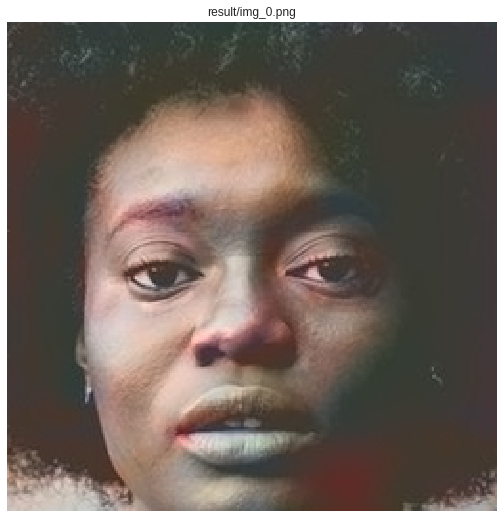

In [16]:
# Show results
!{sys.executable} -m pip install ipywidgets


from ipywidgets import interact
from ipywidgets import widgets
from support import show_img 

def show_sample(sample_n):
    image_path = os.path.join(RESULT, "img_"+str(sample_n-1)+".png")
    img = image.load_img(image_path)
    img = image.img_to_array(img)/255
    ax = show_img(img, figsize=(9,9))
    ax.set_title(image_path)
    
interact(show_sample, sample_n=widgets.IntSlider(value=1, min=1, max=END-START-1, description='Show results of colorization'));

## It's your turn

Test out the model you just trained. Run the code Cell below and enter a URL with your pic in the widget below. Have fun!🎉

Here's some URL for testing:

- (man, colored) http://www.bolsamania.com/cine/wp-content/uploads/2017/03/26-2.jpg
- (landscape, colored) https://cdn.pixabay.com/photo/2017/04/07/18/23/landscape-2211587_960_720.jpg
- (lion, b&w) https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQTXYpHhz45gaDHPsNulPFotlc72i3MDv_1RoOcQjEQx3sX-dWj

**Note**: *You can also consider to use URL of colored pictures, in this way you can fully test the colorization on new images.*

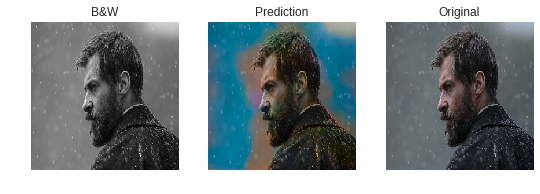

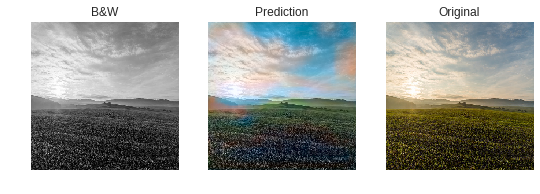

interactive(children=(Text(value='', description='URL', placeholder='Insert URL of a pic'), Button(description…

In [18]:
# Testing on url images
from ipywidgets import interact_manual
from ipywidgets import widgets
from support import prediction_from_url

def get_prediction(URL):
    prediction_from_url(URL, model, inception)

get_prediction('http://www.bolsamania.com/cine/wp-content/uploads/2017/03/26-2.jpg')
get_prediction('https://cdn.pixabay.com/photo/2017/04/07/18/23/landscape-2211587_960_720.jpg')
    
interact_manual(get_prediction, URL=widgets.Text(placeholder='Insert URL of a pic'));


## Save the result

In [0]:
if not os.path.exists('models/'):
    os.makedirs('models/')
WEIGHTS_FILE_NAME = "models/color_tensorflow_ds_small_{}.h5".format(EPOCHS)
model.save_weights(WEIGHTS_FILE_NAME)

In [0]:
# Download weights
from google.colab import files
files.download(WEIGHTS_FILE_NAME)

### What's next

Colorizing images is a deeply fascinating problem. It is as much as a scientific problem as artistic one. I wrote this article so you can get up to speed in coloring and continue where I left off. Here are some suggestions to get started:

- Implement it with another pre-trained model
- A different dataset (you can use **ds-big**)
- Enable the network to grow in accuracy with more pictures
- Build an amplifier within the RGB color space. Create a similar model to the coloring network, that takes a saturated colored image as input and the correct colored image as output.
- Implement a weighted classification
- Use a classification neural network as a loss function. Pictures that are classified as fake produce an error. It then decides how much each pixel contributed to the error.
- *Apply it to video* (This is a killer AI product). Don’t worry too much about the colorization, but make the switch between images consistent. You could also do something similar for larger images, by tiling smaller ones.

##### That's all folks - don't forget to shutdown your workspace once you're done 🙂